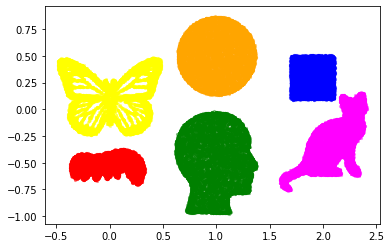

In [307]:
from IPython.display import clear_output
import pdb, time, math, numpy as np, gc, importlib, torch, os, cv2 as cv, ODEModel, matplotlib
import ot
import matplotlib.pyplot as plt
from torch import Tensor, nn
from torch.nn import functional as F 
from torch.autograd import Variable
from torch.distributions import MultivariateNormal
from torchdiffeq import odeint_adjoint as odeint 
from geomloss import SamplesLoss
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
import Utils, LearnVelTraj
importlib.reload(Utils)
from Utils import InputMapping, BoundingBox, ImageDataset, SaveTrajectory, ezshow, SaveTrajectory as st, MiscTransforms
importlib.reload(ODEModel)
from ODEModel import velocMLP, FfjordModel
importlib.reload(LearnVelTraj);
from LearnVelTraj import learn_vel_trajectory

im1 = ImageDataset('frames/butterfly.jpg'); 
im1b = ImageDataset('frames/butterflyfilled.jpg'); 
im2 = ImageDataset('frames/caterpillar.png', noise_std = .005); 
im3 = ImageDataset('frames/circle.jpeg'); 
im4 = ImageDataset('frames/baldhead.jpeg'); 
im5 = ImageDataset('frames/square.png'); 
im6 = ImageDataset('frames/cat1.png'); 

n_inner = 7000;
n_sil = 10000 - n_inner;
d2 = im2.sample(n_inner, n_sil, scale = [-1, -1], center = [0.05, -.5]); 
d1a = im1.sample(n_inner, n_sil, center = [0, 0]); 
d1b = im1b.sample(n_inner, n_sil, center = [0, 0]); 
d3 = im3.sample(n_inner, n_sil, center = [1, .5]); 
d4 = im4.sample(n_inner, n_sil, center = [1, -.5]); 
d5 = im5.sample(n_inner, n_sil, center = [1.9, .3]); 
d6 = im6.sample(n_inner, n_sil, center = [2, -.3]); 

dat1 = torch.cat((d1a[0], d1b[1]),0)
dat2 = torch.cat(d2,0)
dat3 = torch.cat(d3,0)
dat4 = torch.cat(d4,0)
dat5 = torch.cat(d5,0)
dat6 = torch.cat(d6,0)

ezshow(dat1, col='yellow')
ezshow(dat2, col='red')
ezshow(dat3, col='orange')
ezshow(dat4, col='green')
ezshow(dat5, col='blue')
ezshow(dat6, col='magenta')

  0%|          | 1/300 [00:00<03:07,  1.59it/s]

Allocated: 0.05 GB  Reserved: 0.72 GB
[Loss: 1.4979 | lr: 0.0001 | n_subsample: 300] 
[Total time : 0.6299 | Iter: 0.6281 | fit: 0.1846 | reg: 0.1374 | save: 0.0000) | autograd: 0.3039]



 17%|█▋        | 51/300 [00:41<10:01,  2.41s/it]

Allocated: 0.05 GB  Reserved: 0.72 GB
[Loss: 1.0163 | lr: 0.0001 | n_subsample: 378] 
[Total time : 41.6914 | Iter: 35.7005 | fit: 0.2199 | reg: 0.1868 | save: 5.3597) | autograd: 0.3796]



 34%|███▎      | 101/300 [01:30<08:14,  2.48s/it]

Allocated: 0.05 GB  Reserved: 0.72 GB
[Loss: 0.7336 | lr: 0.0001 | n_subsample: 476] 
[Total time : 90.7400 | Iter: 43.7563 | fit: 0.2462 | reg: 0.1674 | save: 5.2908) | autograd: 0.4706]



 50%|█████     | 151/300 [02:23<06:38,  2.67s/it]

Allocated: 0.05 GB  Reserved: 0.72 GB
[Loss: 0.3808 | lr: 0.0001 | n_subsample: 600] 
[Total time : 143.0298 | Iter: 46.4774 | fit: 0.2878 | reg: 0.2164 | save: 5.8099) | autograd: 0.4151]



 67%|██████▋   | 201/300 [03:16<04:18,  2.61s/it]

Allocated: 0.05 GB  Reserved: 0.72 GB
[Loss: 0.2912 | lr: 0.0001 | n_subsample: 756] 
[Total time : 196.0286 | Iter: 47.5147 | fit: 0.2493 | reg: 0.2093 | save: 5.4827) | autograd: 0.4875]



 84%|████████▎ | 251/300 [04:10<02:11,  2.68s/it]

Allocated: 0.05 GB  Reserved: 0.72 GB
[Loss: 0.2488 | lr: 0.0001 | n_subsample: 953] 
[Total time : 250.7381 | Iter: 49.1310 | fit: 0.2852 | reg: 0.2450 | save: 5.5771) | autograd: 0.5081]



100%|██████████| 300/300 [05:07<00:00,  1.02s/it]

Allocated: 0.05 GB  Reserved: 0.72 GB
[Loss: 0.2183 | lr: 0.0001 | n_subsample: 953] 
[Total time : 307.3463 | Iter: 50.9279 | fit: 0.2922 | reg: 0.2161 | save: 5.6785) | autograd: 0.5361]



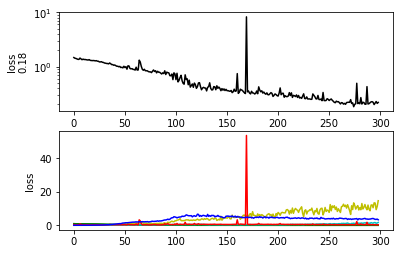

In [315]:
keyframes, __ = ImageDataset.normalize_samples(torch.stack((dat1, dat6, dat2)).to(device));

model = FfjordModel(sigmac = 3, n_freq = 100, hidden_layers=3, hidden_features=512, tdiv = 2, in_features=3, out_features=2, incrementalMask = False).to(device)
outfolder = "results/experiment_debug_losses_detach_moreclipping/"
model, losses, separate_losses, lrs, n_subs, separate_times = learn_vel_trajectory(keyframes, n_iters = 300, n_subsample=300, model=model, outname=outfolder, sqrtfitloss=True, detachTZM = True, clipnorms = True, clipnorm = 1, lr=1e-4)


  0%|          | 1/450 [00:01<09:58,  1.33s/it]

Allocated: 0.03 GB  Reserved: 0.72 GB
[Loss: 1.5346 | lr: 0.0004 | n_subsample: 300] 
[Total time : 1.3331 | Iter: 1.3321 | fit: 0.2073 | reg: 0.1329 | save: 0.0000) | autograd: 0.9899]



 11%|█▏        | 51/450 [01:23<21:53,  3.29s/it]

Allocated: 0.03 GB  Reserved: 0.72 GB
[Loss: 0.8924 | lr: 0.0004 | n_subsample: 378] 
[Total time : 83.7860 | Iter: 76.7178 | fit: 0.2535 | reg: 0.1734 | save: 5.7338) | autograd: 1.0591]



 22%|██▏       | 101/450 [02:55<20:09,  3.47s/it]

Allocated: 0.03 GB  Reserved: 0.72 GB
[Loss: 0.6671 | lr: 0.0004 | n_subsample: 476] 
[Total time : 175.5022 | Iter: 86.1754 | fit: 0.2569 | reg: 0.2407 | save: 5.5389) | autograd: 1.3684]



 34%|███▎      | 151/450 [04:30<17:39,  3.54s/it]

Allocated: 0.03 GB  Reserved: 0.72 GB
[Loss: 0.5331 | lr: 0.0004 | n_subsample: 600] 
[Total time : 270.6774 | Iter: 89.3318 | fit: 0.2799 | reg: 0.2224 | save: 5.8421) | autograd: 1.3235]



 45%|████▍     | 201/450 [06:06<14:38,  3.53s/it]

Allocated: 0.03 GB  Reserved: 0.72 GB
[Loss: 0.4548 | lr: 0.0004 | n_subsample: 756] 
[Total time : 366.4876 | Iter: 90.0382 | fit: 0.2845 | reg: 0.2571 | save: 5.7699) | autograd: 1.3142]



 56%|█████▌    | 251/450 [07:42<11:14,  3.39s/it]

Allocated: 0.03 GB  Reserved: 0.72 GB
[Loss: 0.3109 | lr: 0.0004 | n_subsample: 953] 
[Total time : 462.9148 | Iter: 90.9401 | fit: 0.2580 | reg: 0.1999 | save: 5.4862) | autograd: 1.1358]



 67%|██████▋   | 301/450 [09:18<08:51,  3.57s/it]

Allocated: 0.03 GB  Reserved: 0.72 GB
[Loss: 0.2295 | lr: 0.0004 | n_subsample: 1100] 
[Total time : 558.8070 | Iter: 90.2529 | fit: 0.2688 | reg: 0.2154 | save: 5.6378) | autograd: 1.4300]



 78%|███████▊  | 351/450 [10:52<05:36,  3.40s/it]

Allocated: 0.03 GB  Reserved: 0.72 GB
[Loss: 0.1852 | lr: 0.0004 | n_subsample: 1100] 
[Total time : 652.3544 | Iter: 88.0687 | fit: 0.2619 | reg: 0.1823 | save: 5.4761) | autograd: 1.1949]



 89%|████████▉ | 401/450 [12:29<02:55,  3.59s/it]

Allocated: 0.03 GB  Reserved: 0.72 GB
[Loss: 0.2109 | lr: 0.0004 | n_subsample: 1100] 
[Total time : 749.7786 | Iter: 91.7405 | fit: 0.2782 | reg: 0.2154 | save: 5.6818) | autograd: 1.4422]



100%|██████████| 450/450 [14:05<00:00,  1.88s/it]

Allocated: 0.03 GB  Reserved: 0.72 GB
[Loss: 0.1793 | lr: 0.0004 | n_subsample: 1100] 
[Total time : 845.3707 | Iter: 89.9980 | fit: 0.2677 | reg: 0.2275 | save: 5.5922) | autograd: 1.4500]



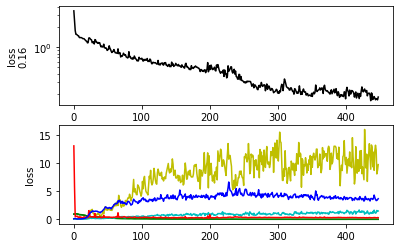

In [305]:
keyframes, __ = ImageDataset.normalize_samples(torch.stack((dat1, dat6, dat2)).to(device));

model = FfjordModel(sigmac = 4, n_freq = 100, hidden_layers=3, hidden_features=512, tdiv = 2, in_features=3, out_features=2, incrementalMask = False).to(device)
outfolder = "results/experiment_debug_losses_no_detach_higherlr/"
model, losses, separate_losses, lrs, n_subs, separate_times = learn_vel_trajectory(keyframes, n_iters = 450, n_subsample=300, model=model, outname=outfolder, sqrtfitloss=True, detachTZM = False, clipnorms = True, lr = 4e-4)


  0%|          | 1/900 [00:01<20:35,  1.37s/it]

Allocated: 0.04 GB  Reserved: 0.72 GB
[Loss: 1.5276 | lr: 0.0001 | n_subsample: 300] 
[Total time : 1.3746 | Iter: 1.3728 | fit: 0.1998 | reg: 0.1391 | save: 0.0000) | autograd: 1.0317]



  6%|▌         | 51/900 [01:17<45:49,  3.24s/it]

Allocated: 0.04 GB  Reserved: 0.72 GB
[Loss: 1.1633 | lr: 0.0001 | n_subsample: 378] 
[Total time : 77.8683 | Iter: 70.8484 | fit: 0.2180 | reg: 0.1509 | save: 5.6433) | autograd: 1.0682]



 11%|█         | 101/900 [02:45<45:54,  3.45s/it]

Allocated: 0.04 GB  Reserved: 0.72 GB
[Loss: 0.9248 | lr: 0.0001 | n_subsample: 476] 
[Total time : 165.3472 | Iter: 81.6540 | fit: 0.2486 | reg: 0.1779 | save: 5.8217) | autograd: 1.2631]



 17%|█▋        | 151/900 [04:16<41:41,  3.34s/it]

Allocated: 0.04 GB  Reserved: 0.72 GB
[Loss: 0.7952 | lr: 0.0001 | n_subsample: 600] 
[Total time : 256.5703 | Iter: 85.7952 | fit: 0.2871 | reg: 0.2571 | save: 5.4253) | autograd: 1.2708]



 22%|██▏       | 201/900 [05:51<41:12,  3.54s/it]

Allocated: 0.04 GB  Reserved: 0.72 GB
[Loss: 0.6410 | lr: 0.0001 | n_subsample: 756] 
[Total time : 351.1438 | Iter: 88.6892 | fit: 0.2925 | reg: 0.2448 | save: 5.8821) | autograd: 1.3138]



 28%|██▊       | 251/900 [07:32<39:11,  3.62s/it]

Allocated: 0.04 GB  Reserved: 0.72 GB
[Loss: 0.5055 | lr: 0.0001 | n_subsample: 953] 
[Total time : 452.1297 | Iter: 95.2456 | fit: 0.3232 | reg: 0.2158 | save: 5.7384) | autograd: 1.2390]



 33%|███▎      | 301/900 [09:16<36:11,  3.63s/it]

Allocated: 0.04 GB  Reserved: 0.72 GB
[Loss: 0.4973 | lr: 0.0001 | n_subsample: 1100] 
[Total time : 556.7918 | Iter: 99.1426 | fit: 0.3492 | reg: 0.2795 | save: 5.5177) | autograd: 1.4918]



 39%|███▉      | 351/900 [11:04<34:53,  3.81s/it]

Allocated: 0.04 GB  Reserved: 0.72 GB
[Loss: 0.4517 | lr: 0.0001 | n_subsample: 1100] 
[Total time : 664.7805 | Iter: 102.1788 | fit: 0.3430 | reg: 0.2893 | save: 5.8077) | autograd: 1.4932]



 45%|████▍     | 401/900 [12:55<32:11,  3.87s/it]

Allocated: 0.04 GB  Reserved: 0.72 GB
[Loss: 0.4173 | lr: 0.0001 | n_subsample: 1100] 
[Total time : 775.8671 | Iter: 105.2059 | fit: 0.3574 | reg: 0.2619 | save: 5.8788) | autograd: 1.4533]



 50%|█████     | 451/900 [14:46<27:47,  3.71s/it]

Allocated: 0.04 GB  Reserved: 0.72 GB
[Loss: 0.4023 | lr: 0.0001 | n_subsample: 1100] 
[Total time : 886.9259 | Iter: 105.6411 | fit: 0.3345 | reg: 0.3091 | save: 5.4156) | autograd: 1.5277]



 56%|█████▌    | 501/900 [16:39<26:08,  3.93s/it]

Allocated: 0.04 GB  Reserved: 0.72 GB
[Loss: 0.4012 | lr: 0.0001 | n_subsample: 1100] 
[Total time : 999.3128 | Iter: 106.4046 | fit: 0.3408 | reg: 0.3088 | save: 5.9798) | autograd: 1.5559]



 61%|██████    | 551/900 [18:32<23:51,  4.10s/it]

Allocated: 0.04 GB  Reserved: 0.72 GB
[Loss: 0.3741 | lr: 0.0001 | n_subsample: 1100] 
[Total time : 1112.8831 | Iter: 107.2883 | fit: 0.3564 | reg: 0.2668 | save: 6.2798) | autograd: 1.5722]



 67%|██████▋   | 601/900 [20:28<21:22,  4.29s/it]

Allocated: 0.04 GB  Reserved: 0.72 GB
[Loss: 0.3552 | lr: 0.0001 | n_subsample: 1100] 
[Total time : 1228.3103 | Iter: 108.4427 | fit: 0.3758 | reg: 0.3124 | save: 6.9764) | autograd: 1.5711]



 72%|███████▏  | 651/900 [22:19<16:04,  3.87s/it]

Allocated: 0.04 GB  Reserved: 0.72 GB
[Loss: 0.3282 | lr: 0.0001 | n_subsample: 1100] 
[Total time : 1339.2439 | Iter: 104.8254 | fit: 0.3539 | reg: 0.2256 | save: 6.1060) | autograd: 1.4492]



 78%|███████▊  | 701/900 [24:12<13:06,  3.95s/it]

Allocated: 0.04 GB  Reserved: 0.72 GB
[Loss: 0.3434 | lr: 0.0001 | n_subsample: 1100] 
[Total time : 1452.1265 | Iter: 106.8682 | fit: 0.3299 | reg: 0.2972 | save: 6.0129) | autograd: 1.6024]



 83%|████████▎ | 751/900 [26:03<09:47,  3.94s/it]

Allocated: 0.04 GB  Reserved: 0.72 GB
[Loss: 0.3347 | lr: 5e-05 | n_subsample: 1100] 
[Total time : 1563.5763 | Iter: 105.4301 | fit: 0.3319 | reg: 0.2823 | save: 6.0187) | autograd: 1.5706]



 89%|████████▉ | 801/900 [27:56<06:43,  4.07s/it]

Allocated: 0.04 GB  Reserved: 0.72 GB
[Loss: 0.3155 | lr: 5e-05 | n_subsample: 1100] 
[Total time : 1676.2257 | Iter: 106.3352 | fit: 0.3510 | reg: 0.2687 | save: 6.3124) | autograd: 1.4983]



 95%|█████████▍| 851/900 [29:47<03:11,  3.92s/it]

Allocated: 0.04 GB  Reserved: 0.72 GB
[Loss: 0.3107 | lr: 5e-05 | n_subsample: 1100] 
[Total time : 1787.6416 | Iter: 105.5427 | fit: 0.3653 | reg: 0.3019 | save: 5.8717) | autograd: 1.4601]



100%|██████████| 900/900 [31:36<00:00,  2.11s/it]

Allocated: 0.04 GB  Reserved: 0.72 GB
[Loss: 0.3103 | lr: 5e-05 | n_subsample: 1100] 
[Total time : 1896.1793 | Iter: 102.6719 | fit: 0.3179 | reg: 0.2817 | save: 5.8635) | autograd: 1.5738]




  0%|          | 1/900 [00:00<11:15,  1.33it/s]

Allocated: 0.04 GB  Reserved: 0.72 GB
[Loss: 1.5584 | lr: 0.0001 | n_subsample: 300] 
[Total time : 0.7530 | Iter: 0.7519 | fit: 0.2043 | reg: 0.1745 | save: 0.0000) | autograd: 0.3699]



  6%|▌         | 51/900 [00:41<35:35,  2.52s/it]

Allocated: 0.04 GB  Reserved: 0.72 GB
[Loss: 1.2196 | lr: 0.0001 | n_subsample: 378] 
[Total time : 41.9132 | Iter: 35.2441 | fit: 0.1985 | reg: 0.1413 | save: 5.9146) | autograd: 0.4024]



 11%|█         | 101/900 [01:29<35:27,  2.66s/it]

Allocated: 0.04 GB  Reserved: 0.72 GB
[Loss: 1.0193 | lr: 0.0001 | n_subsample: 476] 
[Total time : 89.2864 | Iter: 41.4077 | fit: 0.2359 | reg: 0.1930 | save: 5.9639) | autograd: 0.4475]



 17%|█▋        | 151/900 [02:20<33:30,  2.68s/it]

Allocated: 0.04 GB  Reserved: 0.72 GB
[Loss: 0.8368 | lr: 0.0001 | n_subsample: 600] 
[Total time : 140.2052 | Iter: 45.0659 | fit: 0.2525 | reg: 0.1458 | save: 5.8509) | autograd: 0.4792]



 22%|██▏       | 201/900 [03:16<35:42,  3.06s/it]

Allocated: 0.04 GB  Reserved: 0.72 GB
[Loss: 0.6238 | lr: 0.0001 | n_subsample: 756] 
[Total time : 196.2515 | Iter: 49.2824 | fit: 0.2759 | reg: 0.2151 | save: 6.7615) | autograd: 0.5550]



 28%|██▊       | 251/900 [04:17<31:59,  2.96s/it]

Allocated: 0.04 GB  Reserved: 0.72 GB
[Loss: 0.2905 | lr: 0.0001 | n_subsample: 953] 
[Total time : 257.6602 | Iter: 55.3656 | fit: 0.3100 | reg: 0.2511 | save: 6.0411) | autograd: 0.6382]



 33%|███▎      | 301/900 [05:20<29:14,  2.93s/it]

Allocated: 0.04 GB  Reserved: 0.72 GB
[Loss: 0.2269 | lr: 0.0001 | n_subsample: 1100] 
[Total time : 320.4175 | Iter: 56.9218 | fit: 0.3128 | reg: 0.2557 | save: 5.8342) | autograd: 0.6621]



 39%|███▉      | 351/900 [06:23<25:19,  2.77s/it]

Allocated: 0.04 GB  Reserved: 0.72 GB
[Loss: 0.1935 | lr: 0.0001 | n_subsample: 1100] 
[Total time : 383.2304 | Iter: 57.4262 | fit: 0.2965 | reg: 0.1917 | save: 5.3839) | autograd: 0.5893]



 45%|████▍     | 401/900 [07:26<23:24,  2.81s/it]

Allocated: 0.04 GB  Reserved: 0.72 GB
[Loss: 0.1793 | lr: 0.0001 | n_subsample: 1100] 
[Total time : 446.1685 | Iter: 57.2720 | fit: 0.2909 | reg: 0.2319 | save: 5.6650) | autograd: 0.6042]



 50%|█████     | 451/900 [08:29<22:01,  2.94s/it]

Allocated: 0.04 GB  Reserved: 0.72 GB
[Loss: 0.1686 | lr: 0.0001 | n_subsample: 1100] 
[Total time : 509.8763 | Iter: 57.7131 | fit: 0.2960 | reg: 0.2205 | save: 5.9927) | autograd: 0.5907]



 56%|█████▌    | 501/900 [09:34<19:15,  2.89s/it]

Allocated: 0.04 GB  Reserved: 0.72 GB
[Loss: 0.1690 | lr: 0.0001 | n_subsample: 1100] 
[Total time : 574.3994 | Iter: 58.6028 | fit: 0.3170 | reg: 0.1756 | save: 5.9190) | autograd: 0.6052]



 61%|██████    | 551/900 [10:40<18:47,  3.23s/it]

Allocated: 0.04 GB  Reserved: 0.72 GB
[Loss: 0.1650 | lr: 0.0001 | n_subsample: 1100] 
[Total time : 640.2876 | Iter: 59.2890 | fit: 0.3151 | reg: 0.2402 | save: 6.5984) | autograd: 0.6924]



 67%|██████▋   | 601/900 [11:44<14:01,  2.81s/it]

Allocated: 0.04 GB  Reserved: 0.72 GB
[Loss: 0.1578 | lr: 0.0001 | n_subsample: 1100] 
[Total time : 704.2851 | Iter: 58.4717 | fit: 0.2995 | reg: 0.2330 | save: 5.5248) | autograd: 0.6221]



 72%|███████▏  | 651/900 [12:48<11:48,  2.85s/it]

Allocated: 0.04 GB  Reserved: 0.72 GB
[Loss: 0.1699 | lr: 0.0001 | n_subsample: 1100] 
[Total time : 768.3896 | Iter: 58.4737 | fit: 0.2935 | reg: 0.2566 | save: 5.6294) | autograd: 0.6348]



 78%|███████▊  | 701/900 [13:51<09:29,  2.86s/it]

Allocated: 0.04 GB  Reserved: 0.72 GB
[Loss: 0.2251 | lr: 5e-05 | n_subsample: 1100] 
[Total time : 831.5844 | Iter: 57.4301 | fit: 0.2991 | reg: 0.1960 | save: 5.7628) | autograd: 0.5811]



 83%|████████▎ | 751/900 [14:55<07:12,  2.90s/it]

Allocated: 0.04 GB  Reserved: 0.72 GB
[Loss: 0.1368 | lr: 5e-05 | n_subsample: 1100] 
[Total time : 895.6179 | Iter: 58.2838 | fit: 0.3047 | reg: 0.2721 | save: 5.7468) | autograd: 0.6922]



 89%|████████▉ | 801/900 [16:02<04:57,  3.00s/it]

Allocated: 0.04 GB  Reserved: 0.72 GB
[Loss: 0.1341 | lr: 5e-05 | n_subsample: 1100] 
[Total time : 962.1501 | Iter: 60.5036 | fit: 0.3260 | reg: 0.2262 | save: 6.0260) | autograd: 0.7248]



 95%|█████████▍| 851/900 [17:07<02:32,  3.11s/it]

Allocated: 0.04 GB  Reserved: 0.72 GB
[Loss: 0.1289 | lr: 5e-05 | n_subsample: 1100] 
[Total time : 1027.7896 | Iter: 59.3817 | fit: 0.3295 | reg: 0.2615 | save: 6.2555) | autograd: 0.7072]



100%|██████████| 900/900 [18:10<00:00,  1.21s/it]

Allocated: 0.04 GB  Reserved: 0.72 GB
[Loss: 0.1402 | lr: 5e-05 | n_subsample: 1100] 
[Total time : 1090.8867 | Iter: 57.3173 | fit: 0.3051 | reg: 0.2794 | save: 5.7773) | autograd: 0.6912]



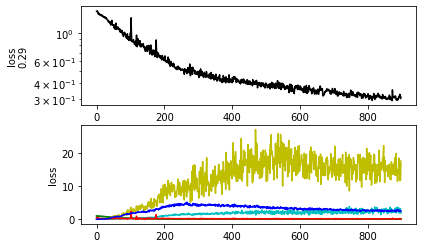

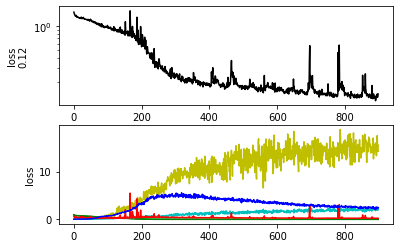

In [297]:
keyframes, __ = ImageDataset.normalize_samples(torch.stack((dat1, dat6, dat2)).to(device));

model = FfjordModel(sigmac = 4, n_freq = 100, hidden_layers=3, hidden_features=512, tdiv = 2, in_features=3, out_features=2, incrementalMask = False).to(device)
outfolder = "results/experiment_debug_losses_no_detach/"
model, losses, separate_losses, lrs, n_subs, separate_times = learn_vel_trajectory(keyframes, n_iters = 900, n_subsample=300, model=model, outname=outfolder, sqrtfitloss=True, detachTZM = False, clipnorms = True)

model = FfjordModel(sigmac = 4, n_freq = 100, hidden_layers=3, hidden_features=512, tdiv = 2, in_features=3, out_features=2, incrementalMask = False).to(device)
outfolder = "results/experiment_debug_losses_detach/"
model, losses, separate_losses, lrs, n_subs, separate_times = learn_vel_trajectory(keyframes, n_iters = 900, n_subsample=300, model=model, outname=outfolder, sqrtfitloss=True, detachTZM = True, clipnorms = True)


In [227]:
keyframes, __ = ImageDataset.normalize_samples(torch.stack((dat1, dat6, dat2)).to(device));

model = FfjordModel(sigmac = 3.5, n_freq = 100, hidden_layers=3, hidden_features=512, tdiv = 2, in_features=3, out_features=2, incrementalMask = True).to(device)
outfolder = "results/experiment_radial_temp/"
model, losses, separate_losses, lrs, n_subs, separate_times = learn_vel_trajectory(keyframes, n_iters = 300, n_subsample=300, model=model, outname=outfolder, sqrtfitloss=True, detachTZM = False)

  0%|          | 0/300 [00:00<?, ?it/s]

> /mnt/pzpzpzp1/wassflow/LearnVelTraj.py(115)learn_vel_trajectory()
    113             zz = z_t.reshape(n_tzm_times*n_tzm_points, dim)
    114             pdb.set_trace()
--> 115             tt = fbt[1:].repeat_interleave(n_tzm_points).reshape(-1, 1)
    116             tzm = torch.cat([tzm, torch.cat([tt, zz], 1)], 0)
    117         if detachTZM:



ipdb>  z_t.shape


torch.Size([5, 30, 2])


ipdb>  tb.shape


torch.Size([6])


ipdb>  tb


tensor([1.0000, 0.8807, 0.6925, 0.4082, 0.3750, 0.2293], device='cuda:0')


ipdb>  q


  0%|          | 0/300 [01:14<?, ?it/s]


BdbQuit: 

In [201]:
import Utils; importlib.reload(Utils); from Utils import SaveTrajectory as st
keyframes, __ = ImageDataset.normalize_samples(torch.stack((dat1, dat6, dat2)).to(device));
model = FfjordModel(sigmac = 3.5, n_freq = 100, hidden_layers=3, hidden_features=512, tdiv = 2, in_features=3, out_features=2, incrementalMask = True).to(device)
model.load_state("results/experiment_radial/models/state_final.tar")
x_trajs = st.save_trajectory(model, keyframes, savename='save_debug', nsteps=20, dpiv=400, n=1000, alpha=1, ot_type=1, writeTracers=True)

In [106]:
keyframes, __ = ImageDataset.normalize_samples(torch.stack((dat1, dat6, dat2)).to(device));

model = FfjordModel(sigmac = 3, n_freq = 100, hidden_layers=3, hidden_features=512, tdiv = 2, in_features=3, out_features=2, incrementalMask = True, initzero = False).to(device)
outfolder = "results/experiment_kurl/"
model, losses, separate_losses, lrs, n_subs, separate_times = learn_vel_trajectory(keyframes, n_iters = 500, n_subsample=300, model=model, outname=outfolder, sqrtfitloss=True, detachTZM = False)


  0%|          | 0/500 [00:00<?, ?it/s]

--Return--
None
> /mnt/pzpzpzp1/wassflow/Utils.py(46)radialKE()
     44         return 30*nn.Softplus(beta)(-dets);
     45     def radialKE(tz,z_dots):
---> 46         pdb.set_trace()
     47 
     48 



ipdb>  tz.shape


torch.Size([600, 3])


ipdb>  x = tz[:,1]; y = tz[:,2];
ipdb>  torch.stack((y, -x),dim=0).shape


torch.Size([2, 600])


ipdb>  dir = torch.stack((y, -x),dim=0)
ipdb>  normalizedCircular = dir/dir.norm(p=2,dim=1)


*** RuntimeError: The size of tensor a (600) must match the size of tensor b (2) at non-singleton dimension 1


ipdb>  dir.shape


torch.Size([2, 600])


ipdb>  y.shape


torch.Size([600])


ipdb>  dir = torch.stack((y, -x), dim=1)
ipdb>  dir.shape


torch.Size([600, 2])


ipdb>  dir.norm(p=2,dim=1).shape


torch.Size([600])


ipdb>  normalizedCircular = dir/dir.norm(p=2,dim=1)


*** RuntimeError: The size of tensor a (2) must match the size of tensor b (600) at non-singleton dimension 1


ipdb>  dir.shape


torch.Size([600, 2])


ipdb>  torch.norm(dir,p=2,dim=1).shape


torch.Size([600])


ipdb>  dir.norm(p=2,dim=1).shape


torch.Size([600])


ipdb>  dir.shape


torch.Size([600, 2])


ipdb>  torch.norm(dir,p=2,dim=1,keepdim=True).shape


torch.Size([600, 1])


ipdb>  normalizedCircular = dir/dir.norm(p=2,dim=1,keepdim=True)
ipdb>  normalizedCircular.shape


torch.Size([600, 2])


ipdb>  z_dots.shape


torch.Size([600, 2])


ipdb>  normalizedCircular.shape


torch.Size([600, 2])


ipdb>  torch.dot(z_dots,normalizedCircular).shape


*** RuntimeError: 1D tensors expected, but got 2D and 2D tensors


ipdb>  (z_dots*normalizedCircular).shape


torch.Size([600, 2])


ipdb>  (z_dots*normalizedCircular).sum(dim=1).shape


torch.Size([600])


ipdb>  q


  0%|          | 0/500 [08:53<?, ?it/s]


BdbQuit: 

  1%|          | 1/150 [00:01<02:53,  1.17s/it]

Allocated: 0.04 GB  Reserved: 0.64 GB
[Loss: 1.4142 | lr: 0.0001 | n_subsample: 300] 
[Total time : 1.1661 | Iter: 1.1645 | fit: 0.1963 | reg: 0.2036 | save: 0.0000) | autograd: 0.7626]



 34%|███▍      | 51/150 [01:25<07:30,  4.55s/it]

Allocated: 0.04 GB  Reserved: 0.64 GB
[Loss: 0.0895 | lr: 0.0001 | n_subsample: 378] 
[Total time : 85.7592 | Iter: 75.8583 | fit: 0.3328 | reg: 0.2743 | save: 8.7323) | autograd: 1.4280]



 67%|██████▋   | 101/150 [03:02<03:30,  4.29s/it]

Allocated: 0.04 GB  Reserved: 0.64 GB
[Loss: 0.0323 | lr: 0.0001 | n_subsample: 476] 
[Total time : 182.8113 | Iter: 88.2122 | fit: 0.3094 | reg: 0.1389 | save: 8.8375) | autograd: 0.9932]



100%|██████████| 150/150 [04:34<00:00,  1.83s/it]

Allocated: 0.04 GB  Reserved: 0.64 GB
[Loss: 0.0293 | lr: 0.0001 | n_subsample: 476] 
[Total time : 274.4461 | Iter: 82.8318 | fit: 0.2965 | reg: 0.1288 | save: 8.8007) | autograd: 1.0328]




  1%|          | 1/150 [00:00<01:49,  1.35it/s]

Allocated: 0.06 GB  Reserved: 0.64 GB
[Loss: 1.4142 | lr: 0.0001 | n_subsample: 300] 
[Total time : 0.7391 | Iter: 0.7374 | fit: 0.1595 | reg: 0.0974 | save: 0.0000) | autograd: 0.4780]



 34%|███▍      | 51/150 [01:02<06:08,  3.72s/it]

Allocated: 0.04 GB  Reserved: 0.64 GB
[Loss: 0.1101 | lr: 0.0001 | n_subsample: 378] 
[Total time : 62.8577 | Iter: 53.6957 | fit: 0.2233 | reg: 0.0691 | save: 8.4203) | autograd: 0.6247]



 67%|██████▋   | 101/150 [02:20<03:21,  4.11s/it]

Allocated: 0.04 GB  Reserved: 0.64 GB
[Loss: 0.0385 | lr: 0.0001 | n_subsample: 476] 
[Total time : 140.0952 | Iter: 68.6479 | fit: 0.2709 | reg: 0.2277 | save: 8.5871) | autograd: 1.0704]



100%|██████████| 150/150 [03:48<00:00,  1.52s/it]

Allocated: 0.04 GB  Reserved: 0.64 GB
[Loss: 0.0286 | lr: 0.0001 | n_subsample: 476] 
[Total time : 228.5824 | Iter: 79.8733 | fit: 0.2826 | reg: 0.1592 | save: 8.6108) | autograd: 1.0802]



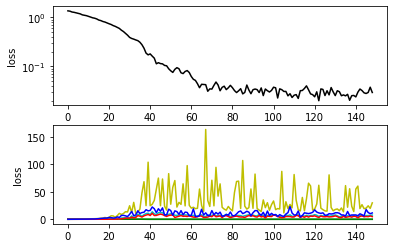

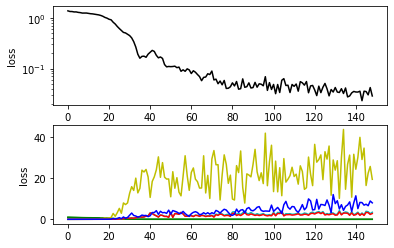

In [26]:
keyframes, __ = ImageDataset.normalize_samples(torch.stack((dat1, dat6, dat2)).to(device));

model = FfjordModel(sigmac = 4, n_freq = 100, hidden_layers=3, hidden_features=512, tdiv = 2, in_features=3, out_features=2, incrementalMask = False, initzero = False).to(device)
outfolder = "results/experiment_without_incremental_mask/"
model, losses, separate_losses, lrs, n_subs, separate_times = learn_vel_trajectory(keyframes, n_iters = 150, n_subsample=300, model=model, outname=outfolder, sqrtfitloss=True)

model = FfjordModel(sigmac = 4, n_freq = 100, hidden_layers=3, hidden_features=512, tdiv = 2, in_features=3, out_features=2, incrementalMask = True, initzero = False).to(device)
outfolder = "results/experiment_with_incremental_mask/"
model, losses, separate_losses, lrs, n_subs, separate_times = learn_vel_trajectory(keyframes, n_iters = 150, n_subsample=300, model=model, outname=outfolder, sqrtfitloss=True)


In [23]:
# establish some baselines. with regularizers and small weight. ~450s for 200 iters.
keyframes, __ = ImageDataset.normalize_samples(torch.stack((dat1, dat6, dat2)).to(device));

model = FfjordModel(sigmac = 4, n_freq = 100, hidden_layers=3, hidden_features=512, tdiv = 2, in_features=3, out_features=2, incrementalMask = True, initzero = False).to(device)
outfolder = "results/experiment_base/"
model, losses, separate_losses, lrs, n_subs, separate_times = learn_vel_trajectory(keyframes, n_iters = 200, n_subsample=300, model=model, outname=outfolder, sqrtfitloss=True)


  0%|          | 1/200 [00:00<03:10,  1.05it/s]

Allocated: 0.03 GB  Reserved: 0.34 GB
[Loss: 1000.0000 | lr: 0.0001 | n_subsample: 300] 
[Total time : 0.9565 | Iter: 0.9548 | fit: 0.1575 | reg: 0.0968 | save: 0.0000) | autograd: 0.6982]


  2%|▏         | 4/200 [00:05<04:05,  1.25s/it]


KeyboardInterrupt: 

  0%|          | 1/300 [00:00<04:38,  1.07it/s]

Allocated: 0.04 GB  Reserved: 0.4 GB
[Loss: 1.4142 | lr: 0.0001 | n_subsample: 300] 
[Total time : 0.9307 | Iter: 0.9288 | fit: 0.1636 | reg: 0.1172 | save: 0.0000) | autograd: 0.6464]


 17%|█▋        | 51/300 [01:13<16:47,  4.05s/it]

Allocated: 0.04 GB  Reserved: 0.4 GB
[Loss: 0.1008 | lr: 0.0001 | n_subsample: 378] 
[Total time : 73.1305 | Iter: 63.5976 | fit: 0.2111 | reg: 0.1375 | save: 8.5986) | autograd: 1.0661]


 34%|███▎      | 101/300 [02:44<14:57,  4.51s/it]

Allocated: 0.04 GB  Reserved: 0.4 GB
[Loss: 0.0338 | lr: 0.0001 | n_subsample: 476] 
[Total time : 164.7504 | Iter: 82.8708 | fit: 0.2317 | reg: 0.1761 | save: 8.7456) | autograd: 1.3259]


 50%|█████     | 151/300 [04:53<12:37,  5.08s/it]

Allocated: 0.04 GB  Reserved: 0.4 GB
[Loss: 0.0321 | lr: 0.0001 | n_subsample: 600] 
[Total time : 293.0161 | Iter: 119.3900 | fit: 0.3070 | reg: 0.1675 | save: 8.8723) | autograd: 1.8464]


 67%|██████▋   | 201/300 [06:59<08:07,  4.93s/it]

Allocated: 0.04 GB  Reserved: 0.4 GB
[Loss: 0.0331 | lr: 0.0001 | n_subsample: 756] 
[Total time : 419.7901 | Iter: 118.0282 | fit: 0.2766 | reg: 0.1524 | save: 8.7414) | autograd: 1.8436]


 84%|████████▎ | 251/300 [09:03<03:58,  4.87s/it]

Allocated: 0.04 GB  Reserved: 0.4 GB
[Loss: 0.0206 | lr: 0.0001 | n_subsample: 953] 
[Total time : 543.3498 | Iter: 114.8276 | fit: 0.2734 | reg: 0.1700 | save: 8.7290) | autograd: 1.6347]


100%|██████████| 300/300 [10:53<00:00,  2.18s/it]


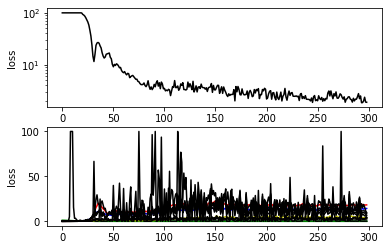

In [72]:
keyframes, __ = ImageDataset.normalize_samples(torch.stack((dat1, dat6, dat2)).to(device));

model = FfjordModel(sigmac = 4, n_freq = 100, hidden_layers=3, hidden_features=512, tdiv = 2, in_features=3, out_features=2, incrementalMask = True).to(device)
outfolder = "results/experiment_relweight/"
model, losses, separate_losses, lrs, n_subs, separate_times = learn_vel_trajectory(keyframes, n_iters = 300, n_subsample=300, model=model, outname=outfolder, sqrtfitloss=True)
st.save_losses(losses, separate_losses, outfolder=outfolder, maxcap=100)

In [ ]:
keyframes, __ = ImageDataset.normalize_samples(torch.stack((dat1, dat6, dat2)).to(device));
sigmacs = range(2,8)
models = []
lossess = []
separate_lossess = []
separate_timess = []
for sigmaci in range(len(sigmacs)):
    sigmac = sigmacs[sigmaci]
    model = FfjordModel(sigmac = 2, n_freq = 100, hidden_layers=3, hidden_features=512, tdiv = 2, in_features=3, out_features=2, incrementalMask = True).to(device)
    outfolder = "results/experiment3_sigma_" + f"{sigmac:02}/"
    model, losses, separate_losses, lrs, n_subs, separate_times = learn_vel_trajectory(keyframes, n_iters = 100, n_subsample=300, model=model, outname=outfolder, sqrtfitloss=True)
    st.save_losses(losses, separate_losses, outfolder=outfolder)
    models.append(model);    lossess.append(losses);    separate_lossess.append(separate_losses);    separate_timess.append(separate_times)

  1%|          | 1/100 [00:00<01:26,  1.14it/s]

Allocated: 0.03 GB  Reserved: 0.38 GB
[Loss: 1.4142 | lr: 0.0001 | n_subsample: 300] 
[Total time : 0.8729 | Iter: 0.8712 | fit: 0.1615 | reg: 0.0960 | save: 0.0000) | autograd: 0.6118]


 19%|█▉        | 19/100 [00:19<01:21,  1.01s/it]


KeyboardInterrupt: 

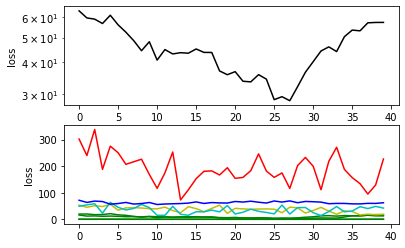

In [16]:
import Utils; importlib.reload(Utils); from Utils import SaveTrajectory as st
st.save_losses(losses, separate_losses, outfolder=outfolder, maxcap=10000, start = 60, end = 500)